In [1]:
# IMPORTS

import numpy as np
from glob import glob
import noisereduce as nr
import random
import librosa.display
import IPython
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import butter, lfilter, freqz



2022-12-06 09:31:46.380424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DIRECTORY CONTAINING PREPROCESSED KICK SPECTROGRAMS
data_dir = '/Volumes/CE_CADDY/TRAINING_SAMPLES/Kicks_Preprocessed_0.5s'

In [3]:
##### FUNCTIONS

## LOAD DATA
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

## REMOVE NANS FROM DATA
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data

######
#LOWPASS FILTERING

order = 4
cutoff = 500 #Hz

def butter_lowpass(cutoff, sr, order):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, sr, order):
    b, a = butter_lowpass(cutoff, sr, order=order)
    y = lfilter(b, a, data)
    return y

######

## POST-PROCESS AND PLAY GENERATED SPECTROGRAMS
def postproc_and_play_kick(generated_spectrogram):
    #sample rate
    sr = 48000
    # random value to pitch down sample
    pdown = random.uniform(-40, -16)
    # spectrogram back to audio
    new_kick = librosa.griffinlim(generated_spectrogram, n_iter=256, hop_length=300, center=True, momentum = 0.1) #, n_iter=64, hop_length=400, center=True
    # noise reduction on audio
    new_kick_nr = nr.reduce_noise(y=new_kick, sr=sr, stationary=True, prop_decrease = 1.0, freq_mask_smooth_hz =300) #, 
    # pitch down audio by random amount
    new_kick_final = librosa.effects.pitch_shift(new_kick_nr, sr=sr, n_steps = pdown, bins_per_octave=16, res_type='kaiser_best')
    #LOWPASS
    new_kick_final = butter_lowpass_filter(new_kick_final, cutoff, sr, order)
    # display waveform and return player for audio file
    librosa.display.waveshow(new_kick_final,sr=sr)
    return IPython.display.Audio(new_kick_final, rate=sr)

In [4]:
# LOAD DATA
data = load_data(data_dir)

In [5]:
# CHECK DATA SHAPE BEFORE REMOVING NANS
data.shape

(6561, 256, 94)

In [6]:
# CHECK NANS IN DATA
np.isnan(data).sum()

0

In [7]:
# REMOVE NANS
data = remove_nans(data)

In [8]:
# CREATE TRAINING AND VALIDATION SETS
X_train = data[:5000, :, :]
X_valid = data[5000:6560, :, :]

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [10]:
codings_size = 10

In [11]:
w = data.shape[1]
h = data.shape[2]

In [12]:
w

256

In [13]:
h

94

encoder, mean and log_var take in same input from second layer hense not being sequential

In [14]:
inputs = layers.Input(shape=[w,h])
z = layers.Flatten()(inputs)
z = layers.Dense(300, activation='relu')(z)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

2022-12-06 09:31:59.214497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


decoder

In [15]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(w * h, activation='sigmoid')(x)
outputs = layers.Reshape([w, h])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [16]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

In [17]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/w*h)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [18]:
# variational_ae.summary()

In [19]:
# SOME VARIABLES FOR GENERATION
hop_length = 300
win_length = 1200
sr = 48000
s_devs = 3

In [20]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
40/40 [==============================] - 12s 261ms/step - loss: 127425.1484 - val_loss: 1.0266
Epoch 2/100
40/40 [==============================] - 10s 258ms/step - loss: 1.3737 - val_loss: 0.6422
Epoch 3/100
40/40 [==============================] - 10s 258ms/step - loss: 1.0838 - val_loss: 0.3275
Epoch 4/100
40/40 [==============================] - 10s 257ms/step - loss: 0.8333 - val_loss: 0.4357
Epoch 5/100
40/40 [==============================] - 10s 254ms/step - loss: 0.7197 - val_loss: 0.4305
Epoch 6/100
40/40 [==============================] - 10s 250ms/step - loss: 0.8386 - val_loss: 0.5146
Epoch 7/100
40/40 [==============================] - 10s 260ms/step - loss: 1.1463 - val_loss: 0.4935
Epoch 8/100
40/40 [==============================] - 10s 259ms/step - loss: 0.9018 - val_loss: 0.5915
Epoch 9/100
40/40 [==============================] - 9s 233ms/step - loss: 0.6653 - val_loss: 0.1492
Epoch 10/100
40/40 [==============================] - 10s 259ms/step - loss: 0

In [21]:
# SAMPLE THE LATENT SPACE
codings = tf.random.normal(shape=[100, codings_size],stddev=s_devs)
images = variational_decoder(codings).numpy()

In [22]:
# variational_ae.summary()

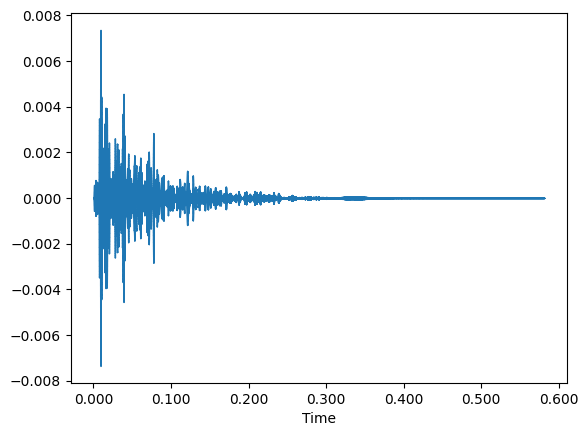

In [23]:
postproc_and_play_kick(images[2])

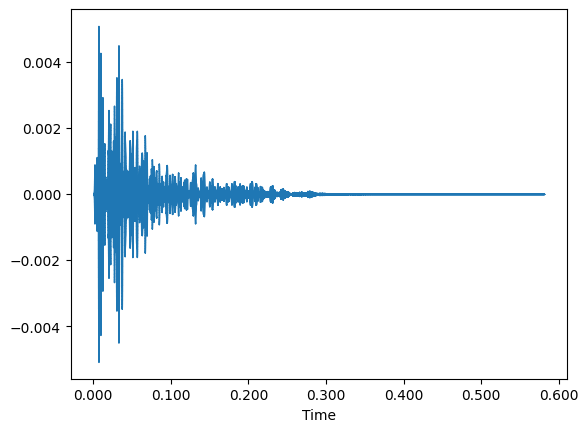

In [24]:
postproc_and_play_kick(images[2])

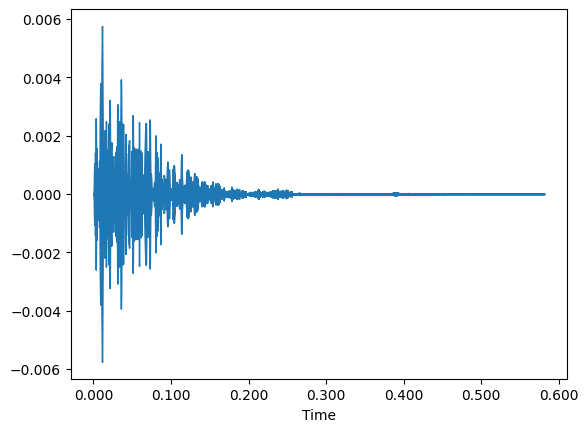

In [25]:
postproc_and_play_kick(images[3])

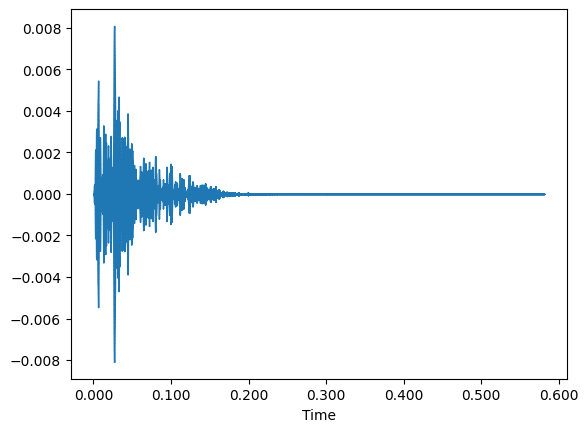

In [26]:
postproc_and_play_kick(images[4])

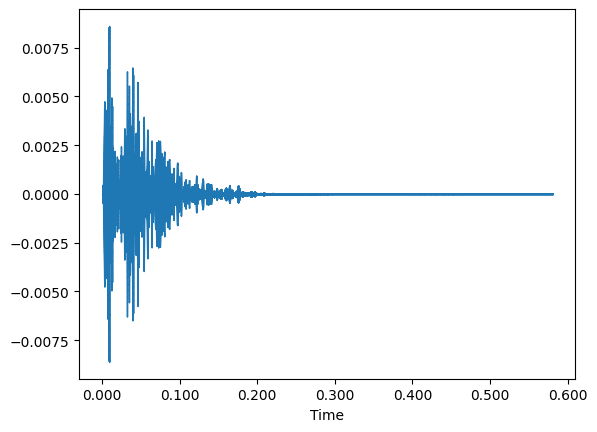

In [27]:
postproc_and_play_kick(images[5])

In [28]:
np.save('kicks_100', images)